# 4 - Aprendizado Profundo

O aprendizado profundo consiste em técnicas de aprendizado de máquina que usam algoritmos baseados em Redes Neurais Artificiais. Existem várias arquiteturas possíveis para essas redes. Neste notebook vamos explorar uma Rede CNN (Convolutional Neural Network) usada para classificação de imagens.

--------------------------------
## 1- Convolutional Neural Network usando Keras e TensorFlow

#### Descrição geral:
Vamos usar o dataset CIFAR 10, uma coleção de 60 mil imagens. As imagens são divididas em 10 classes, sendo 6000 exemplos para da classe. Ele é um subconjunto do 80 Million Tiny Images, contendo 80 mil imagens que foram rotuladas por estudantes.

#### Objetivo:
Neste exemplo, queremos criar um sistema de classificação automático para imagens, onde dada uma imagem é uma entrada que é classificada em uma das 10 classes.


#### Features (variáveis de entrada):
- Imagem: matriz de 32x32, RGB (3 canais de cores)

#### Alvo (valor de saída):
- Classe da imagem: 
    *   Aviões
    *   Carros
    *   Pássaros
    *   Gatos
    *   Veados
    *   Cachorros
    *   Sapos
    *   Cavalos
    *   Návios
    *   Caminhões

#### Referências:
- https://paperswithcode.com/dataset/cifar-10 
- https://en.wikipedia.org/wiki/CIFAR-10

In [2]:
# Bibliotecas gerais
import numpy as np                     # Trabalhar co números
import pandas as pd                    # Trabalhar com tabelas
import matplotlib.pyplot as plt        # Gráficos

# Bibliotecas para construir redes neurais
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

# Aprendizado de máquina geral - Separação treino/teste, transformação (escalonamento), métricas de desempenho
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

### 1 - Passo 1 e 2: carregando os dados e separando os dados

O Keras possui uma API para carregar o Cifar-10 por se tratar de um dataset amplamente conhecido e usado. Perceba que ao carregar usando a biblioteca, já estamos separando as imagens em treino e teste. 

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


Plotando algumas das imagens:

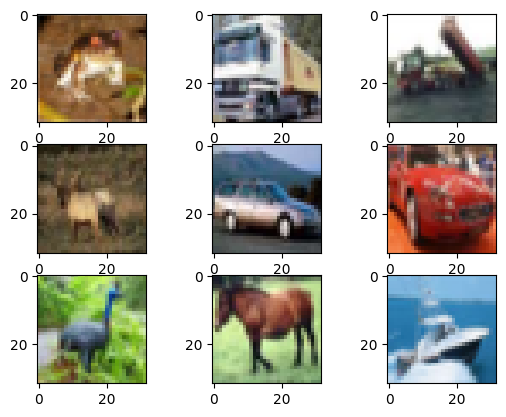

In [4]:
for i in range(9):  
    plt.subplot(330 + 1 + i) # define subplot
    plt.imshow(train_images[i]) # plot raw pixel data
# show the figure
plt.show()

Temos um total de 0000 imagens diferentes com dimensão de 32x32x3 pixels:

In [5]:
len(train_images), len(train_labels), len(test_images), len(test_labels)

(50000, 50000, 10000, 10000)

In [6]:
train_images.shape

(50000, 32, 32, 3)

### 1 - Passo 3: trasnformação dos rótulos e imagens

Vamos transformar os rótulos que estão em arrays numéricos em uma matriz de categorias.

Ver https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical.

In [7]:
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [8]:
train_labels = tf.keras.utils.to_categorical(train_labels)
train_labels.shape

(50000, 10)

In [9]:
test_labels = tf.keras.utils.to_categorical(test_labels)
test_labels.shape

(10000, 10)

Lembre-se, cada imagem é uma matriz de números (no caso RGB, três matrizes). Cada posição da matriz é chamada de pixel, e possui um valor de intensidade.

Em uma imagem RGB 8 bits, a intesidade de cada cor tem um valor inteiro entre 0 e 255 ($2^8$ - ou seja, 8 bits de codificação por valor). Vamos normalizar esse valor para ficar entre 0 e 1. Ao dividir a matriz por um mesmo número, estamos divindo o valor de cada pixel por esse número.

In [10]:
# Normalizando os valores dos pixel para serem entre 0 e 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### 1 - Passo 4': Criando a Arquitetura da Rede Neural Artificial

Para processamento de imagens podemos usar **redes neurais convolucionais**. Esse tipo de rede tem seus parâmetros em uma matriz (*kernel*) que processa toda a imagem passando por todos os seus pixels. Essa matriz são os parâmetros que serão aprendidos pela rede. Esse procedimento de multiplicação entre parte da imagem e a matriz de kernel é semelhante a uma operação de convolução de sinais. Daí o nome do método.

No exemplo da imagem acima, podemos perceber que a convolução é uma operação que pode reduzir a dimensão da entrada, uma vez que tinhamos uma imagem de 7x7 pixels na entrada e como saída final ficamos com 5x5 pixels.

Neste exemplo temos uma convolução ocorrendo numa imagem com um único canal. Entretanto, uma das formas de representações é o espaço de cores RGB. A imagem abaixo ilustra o exemplo da clássica imagem da lenna nesse espaço de cores:

A união dos três canais forma a imagem colorida (256x256x3). Dessa forma a convolução irá operar nos três canais, tendo um *kernel* para cada canal.

O exemplo acima é aplicado quande deseja-se transformar os três canais de convolução em uma única saída.

No nosso modelo de Rede Neural, vamos conectar sequencialmente diferentes camadas com diferentes propósitos. Após a primeira camada de entrada, vamos passar por duas camadas de Convolução.

Perceba que as funções de ativação das camadas de convolução é uma função tipo ReLu. Na primeira camada densa, também, e na última camada da rede, é uma função Softmax já que queremos fazer classificação.

Na sequência das camadas de Convolução, temos uma camada de **Max Pooling**. Essa camada é utilizada para fazer com que a rede seja invariante a pequenas alterações na posição da imagem nos pixels de entrada.

Ver https://keras.io/api/layers/pooling_layers/max_pooling2d/


Temos também a camada de **Flatten** que apenas irá transformar a saída da convolução que é bidimensional em uma dimensão. Isso é feito para que posteriormente seja possível implementar uma **rede neural densa** (como a rede Multilayer Perceptron), já que esse espera como entrada um vetor:

In [ ]:
modelo = tf.keras.Sequential()

modelo.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3))) # Entra com imagem 32,32,3
modelo.add(Conv2D(32, (3, 3), activation='relu')) # Segunda camada convolucional
modelo.add(MaxPooling2D((2, 2),))                 # Camada de MaxPooling
modelo.add(Conv2D(32, (3, 3), activation='relu')) # Terceira camada convolucional 
modelo.add(Flatten())                             # 
modelo.add(Dense(16, activation='relu'))          # Camada totalmente conectada
modelo.add(Dense(10, activation='softmax'))       # Camada totalmente conectada para classificação

modelo.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]) # Métricas para treinar

In [ ]:
modelo.summary()

In [ ]:
plot_model(modelo, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 1 - Passo 4 - Realizando o treinamento do algoritmo

In [ ]:
# Vamos fazer o treinamento utilizando 35 epocas!
history = modelo.fit(train_images,train_labels,epochs=30, verbose=1, batch_size=120, validation_split=0.2)

In [ ]:
# Plotando o MSE para cada época de treinamento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Função de Custo vs Época')
plt.ylabel('Função de Custo')
plt.xlabel('Épocas')
plt.legend(['treino', 'validação'], loc='upper right')
plt.show()

Podemos perceber que nesse primeiro treinamento houve um overfitting, uma vez que o confjunto de validação após 10 épocas de treinamento começou a aumentar o valor da sua função custo.


## Criando um novo modelo

Agora vamos criar um segundo novo modelo para tentar conseguir um resultado diferente no treinamento:

In [ ]:
model= tf.keras.Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu', padding='same')) 
model.add(Dropout(0.2)) 
model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
model.add(Dropout(0.2)) 
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) 
model.add(Dropout(0.2)) 
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten()) 
model.add(Dropout(0.2)) 
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.2)) 
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

O **padding** é uma forma de realizar a convolução sem alterar a dimensão da saída da operação de convolução.

Ver https://keras.io/api/layers/convolution_layers/convolution2d/

O **Dropout** é uma técnica que faz com que alguns neurônios seja desativados aleatoriamente durante o treinamento. O objetivo disso é que evitar o Overfitting. Seria o similar a treinarmos diferentes redes e obtermos a média delas como saída. No caso o dropout irá eliminar 20% dos neurônios durante o treinamento.

Realizando o novo treinamento;

In [ ]:
# Vamos fazer o treinamento utilizando 10 epocas!
history_2 = model.fit(train_images,train_labels,epochs=10, verbose=1, batch_size=120, validation_split=0.2)

In [ ]:
model.save('CNN_Classificador_2.h5')

In [ ]:
# Plotando o MSE para cada época de treinamento
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Função de Custo vs Época')
plt.ylabel('Função de Custo')
plt.xlabel('Épocas')
plt.legend(['treino', 'validação'], loc='upper right')
plt.show()

### Avaliando o desempenho do classificador

Agora, usando a porção de dados de teste, iremos realizar as previsões de todos os valores de saída.

Vamos utilizar o modelo ser Overfitting.

In [ ]:
novo_modelo = load_model('CNN_Classificador_2.h5')

In [ ]:
y_pred = novo_modelo.predict(test_images).argmax(axis=1)
y_pred

In [ ]:
cm_rn = confusion_matrix(test_labels, y_pred, labels = [0,1,2,3,4,5,6,7,8,9])
cm_rn

In [ ]:
figure = plt.figure(figsize=(30, 20))
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rn, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(values_format='d') 

In [ ]:
# Metricas de precisão, revocação, f1-score e acurácia.
print(classification_report(test_labels, y_pred))

------------------------
## 2 - LDL Papaer

Outros exemplos:

No link https://github.com/hfarruda/deeplearningtutorial há uma gama de notebooks para diferentes arquiteturas de redes neurais. Vamos explorar alguns deles.